$Q(s, a; \theta) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q(s', a'; \theta') \middle| s, a \right]$

* Q 是状态 s 和动作 a 下的 Q 值，参数 θ 表示 Q 网络的参数。
* $r_t$ 是当前步的奖励。
* $\gamma$ 是折扣因子，让未来的收益打折
* $max_{a'} Q$ 是下一步状态 $s'$中最大的 Q 值，$a'$ 是 $s'$ 中所有动作

Q 度量的是当前状态和动下下，且未来总用最优动作带来的回报折现

学习更新的方法

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right)$

## 用神经网络代替 Q

In [62]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt

In [80]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        layer2 = F.leaky_relu(self.fc2(layer1), negative_slope=0.01)
        actions = self.fc3(layer2)
        return actions
    

In [75]:
class Agent():
    def __init__(self, input_dims,n_actions,lr,gamma=0.99,epsilon=1.0,ep_dec=1e-5,ep_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = ep_dec
        self.eps_min = ep_min
        self.n_action_space = [i for i in range(n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)

        return action
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        cur_state = T.tensor(state, dtype=T.float).to(self.Q.device)
        cur_action = T.tensor(action).to(self.Q.device)
        cur_reward = T.tensor(reward).to(self.Q.device)
        next_states = T.tensor(state_, dtype=T.float).to(self.Q.device)

        q_pred = self.Q.forward(cur_state)[cur_action]

        q_next = self.Q.forward(next_states).max()

        q_target = cur_reward + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [76]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    plt.savefig(filename)

In [81]:
env = gym.make('CartPole-v1')

In [18]:
env.action_space.n

2

In [45]:
obs_, reward, terminated, truncated, info = env.step(action)
obs_, reward, terminated, truncated, info

(array([ 0.02288327, -0.19105881,  0.02033674,  0.3403878 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [57]:
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
obs = env.reset()
action = agent.choose_action(obs)
obs_, reward, terminated, truncated, info = env.step(action)
obs[0],action,obs_, reward, terminated, truncated, info



(array([-0.00490873, -0.01135814,  0.01391778, -0.01364402], dtype=float32),
 0,
 array([-0.00513589, -0.2066769 ,  0.0136449 ,  0.28339744], dtype=float32),
 1.0,
 False,
 False,
 {})

In [82]:
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
n_games = 10000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.learn(obs, action, reward, obs_)
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print(f'episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}')


episode 0 score 27.0 average score 27.0 epsilon 0.9997300000000012
episode 100 score 12.0 average score 21.29 epsilon 0.9784400000000981
episode 200 score 17.0 average score 22.9 epsilon 0.9555400000002023
episode 300 score 15.0 average score 22.66 epsilon 0.9328800000003055
episode 400 score 51.0 average score 20.9 epsilon 0.9119800000004006
episode 500 score 27.0 average score 23.79 epsilon 0.8881900000005089
episode 600 score 12.0 average score 25.09 epsilon 0.863100000000623
episode 700 score 17.0 average score 22.39 epsilon 0.8407100000007249
episode 800 score 51.0 average score 22.37 epsilon 0.8183400000008267
episode 900 score 24.0 average score 26.78 epsilon 0.7915600000009486
episode 1000 score 17.0 average score 23.5 epsilon 0.7680600000010556
episode 1100 score 58.0 average score 24.58 epsilon 0.7434800000011674
episode 1200 score 11.0 average score 22.37 epsilon 0.7211100000012692
episode 1300 score 10.0 average score 26.2 epsilon 0.6949100000013885
episode 1400 score 28.0 

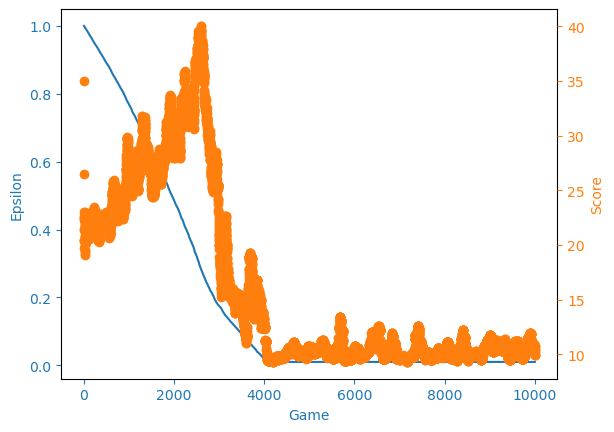

In [79]:
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)